# Rt Live Model

In [1]:
%load_ext autoreload
%autoreload 2

import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data, summarize_inference_data

## Fetch data and select the state's data

In [2]:
df = get_and_process_covidtracking_data(run_date=pd.Timestamp.today()-pd.Timedelta(days=1))

In [3]:
region = "OR"
model_data = df.loc[region]

## Create the model instance and sample

In [4]:
gm = GenerativeModel(region, model_data)
gm.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 2583 seconds.


## Summarize Model Output

In [5]:
result = summarize_inference_data(gm.inference_data)

In [6]:
result.tail(10)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-07-09,0.972486,0.963270,0.810908,1.121034,151.342281,177.505286,167.615777,371.0,5808.0
2020-07-10,0.975264,0.967215,0.826539,1.160618,151.034499,177.609385,148.666677,266.0,4695.0
2020-07-11,0.975046,0.967138,0.801802,1.137485,150.789663,177.569623,192.450956,397.0,5413.0
2020-07-12,0.975227,0.963865,0.803364,1.148740,150.637534,177.411543,209.842881,319.0,3989.0
2020-07-13,0.973827,0.962592,0.791003,1.145089,150.600816,177.163220,154.898258,268.0,4540.0
2020-07-14,0.974817,0.965767,0.785595,1.146241,150.660394,176.849557,202.996700,367.0,4744.0
2020-07-15,0.973511,0.967554,0.783502,1.144844,150.799131,176.493298,114.412366,276.0,6330.0
2020-07-16,0.973872,0.962383,0.795836,1.184100,151.041317,176.117298,156.854990,428.0,7160.0
2020-07-17,0.975903,0.962704,0.748603,1.148470,151.395051,175.740187,146.473359,293.0,5249.0


## Plot Model Output

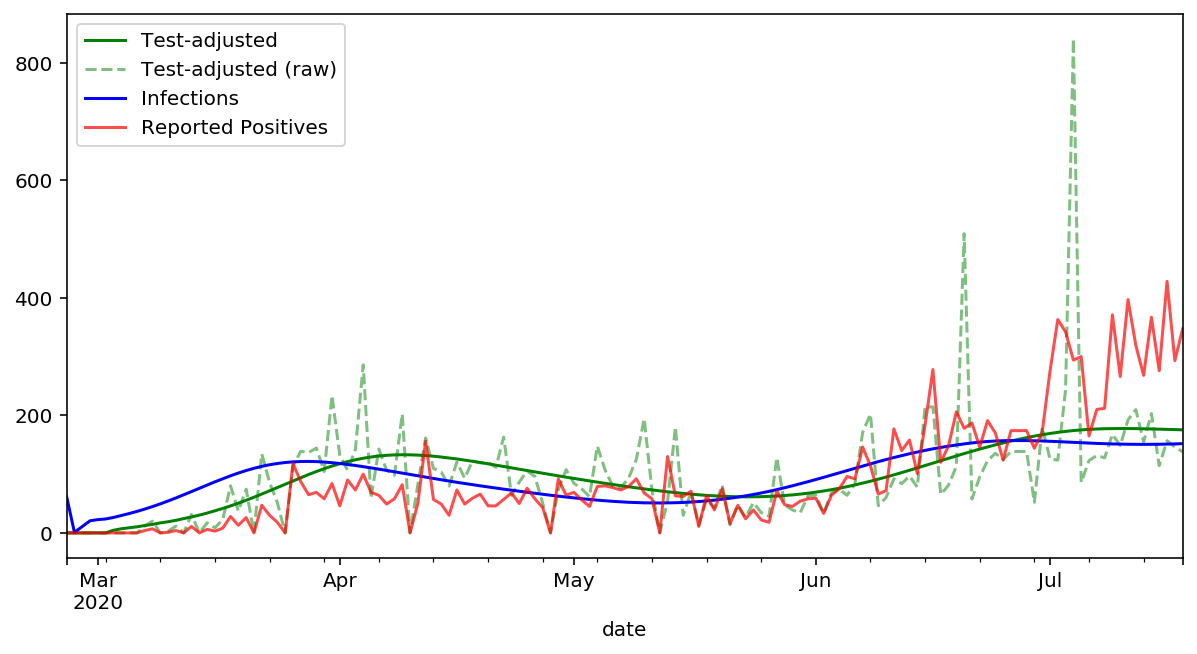

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
result.test_adjusted_positive.plot(c="g", label="Test-adjusted")
result.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
result.infections.plot(c="b", label="Infections")
gm.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
fig.set_facecolor('w')
ax.legend();

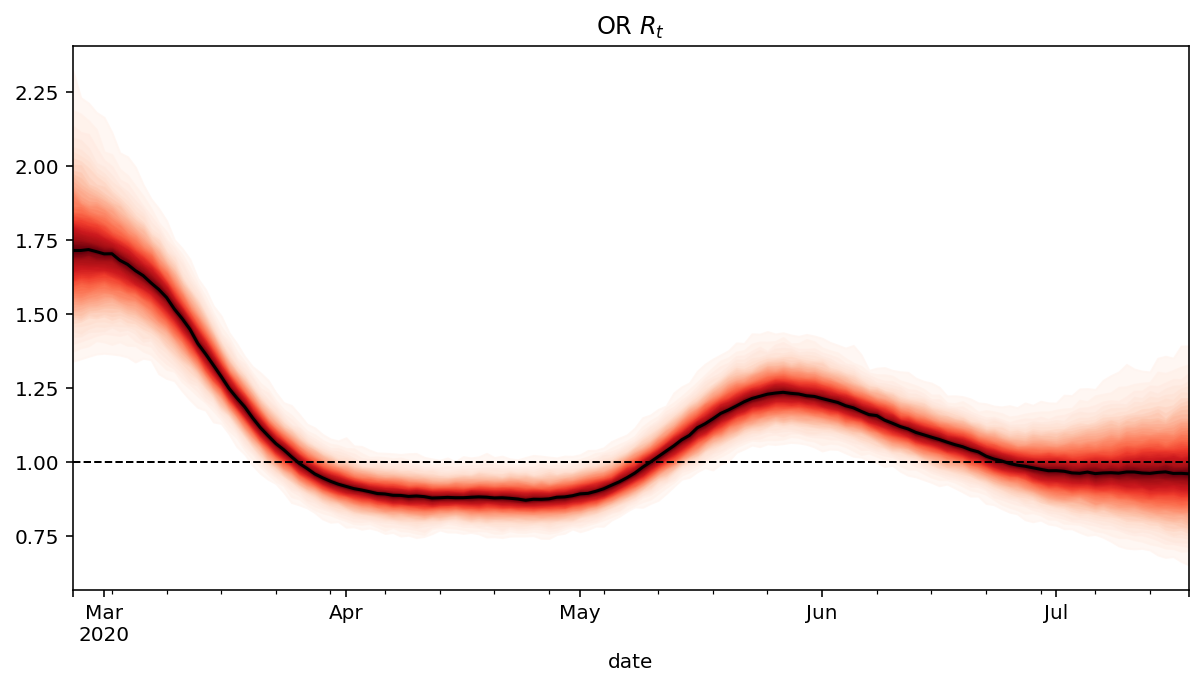

In [8]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} $R_t$")
samples = gm.trace['r_t']
x=result.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

result["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
fig.set_facecolor('w')